Predicting wind speed using ARIMA.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels as sm

In [2]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

In [3]:
import statsmodels.api  as sm

In [4]:
from sklearn.metrics import mean_squared_error , r2_score

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
train.head()

,Date,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [7]:
test.head()

,Date,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-12-26 00:00:00,394.483887,11.23912,3350.492384,25.707260
1,2018-12-26 00:10:00,369.472809,11.01617,3278.121125,25.653749
2,2018-12-26 00:20:00,342.465393,10.68914,3151.278731,26.026560
3,2018-12-26 00:30:00,379.872101,10.95354,3255.790569,25.367300
4,2018-12-26 00:40:00,346.712891,10.38256,3007.924280,24.966379


In [8]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [11]:
cols = train.columns.tolist()

In [12]:
train.set_index(['Date'] , inplace = True)
test.set_index(['Date'] , inplace = True)

Text(0.5, 1.0, 'Wind Speed (m/s)')

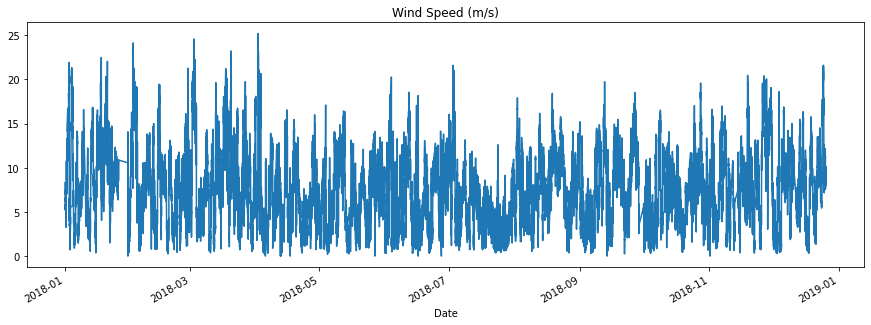

In [31]:
## plot wind speed 
plt.figure(figsize = (15,5))
train[cols[2]].plot()
plt.title(cols[2])

Text(0.5, 1.0, '30 min mean wind speed ')

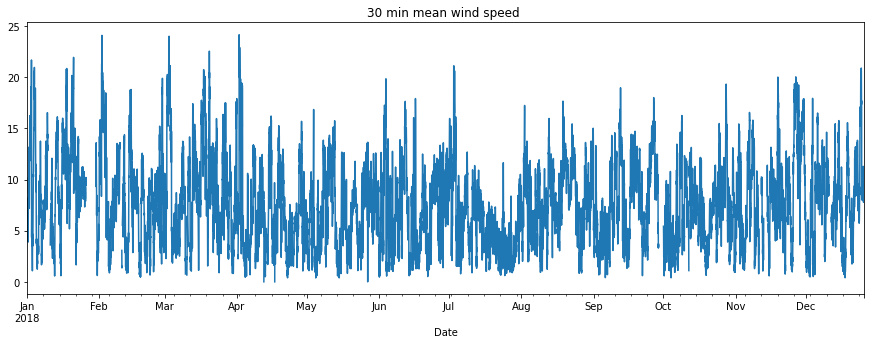

In [32]:
## 30 MINS interval wind speed and hourly wind speed
plt.figure(figsize = (15,5))
train.resample('30min')[cols[2]].mean().plot(label = '30 min mean')
plt.title("30 min mean wind speed ")

Text(0.5, 1.0, 'Hourly mean wind speed ')

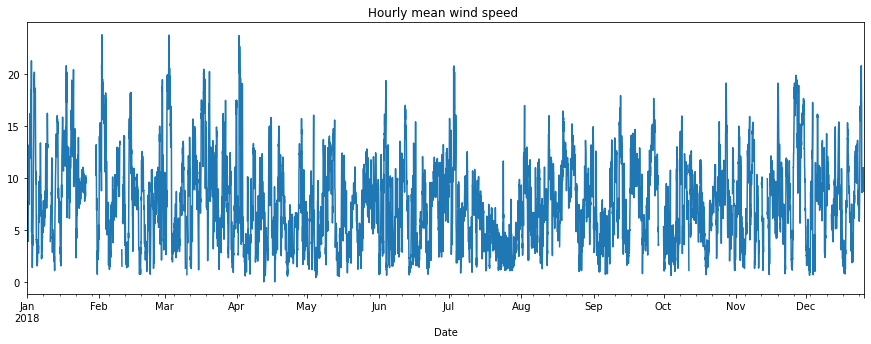

In [33]:
plt.figure(figsize = (15,5))
train.resample('H')[cols[2]].mean().plot()
plt.title("Hourly mean wind speed ")

Text(0.5, 1.0, 'Wind Speed (m/s)')

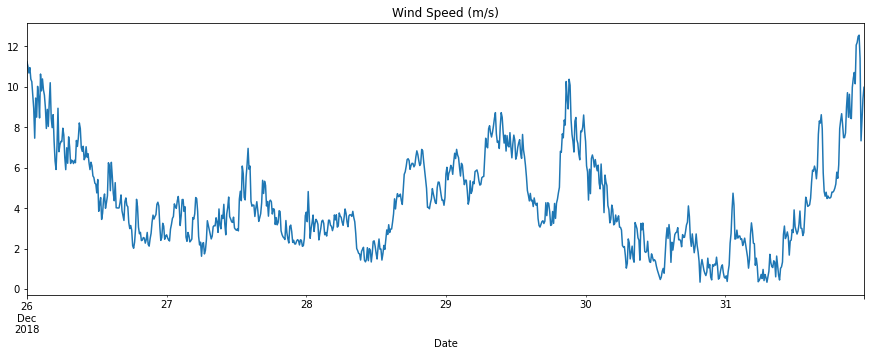

In [34]:
## plot test data 
plt.figure(figsize = (15,5))
test[cols[2]].plot()
plt.title(cols[2])

In [35]:
train_ws = train[cols[2]]
test_ws = test[cols[2]]

In [37]:
## Check for Stationarity of the time series 

result = adfuller(train_ws, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(train_ws, regression='ct')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -14.479536765418167
p-value: 6.406391076109656e-27
Critial Values:
   1%, -3.43048170680721
Critial Values:
   5%, -2.8615982116949237
Critial Values:
   10%, -2.5668009841615333

KPSS Statistic: 1.746636
p-value: 0.010000
Critial Values:
   10%, 0.119
Critial Values:
   5%, 0.146
Critial Values:
   2.5%, 0.176
Critial Values:
   1%, 0.216


/Users/anushabanninthaya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/anushabanninthaya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


The KPSS Test shows that the series is stationary.  

<Figure size 1080x360 with 0 Axes>

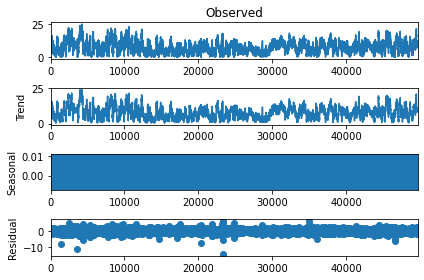

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
## Seasonal decompose 
plt.figure(figsize = (15,5))
seasonal_decompose(train_ws.values , period = 6).plot(); ## Since the function gave an error for Freq of 'T', 
## the work around is set the period to 2 and pass an array to the function.


In [39]:
from pandas.plotting import autocorrelation_plot

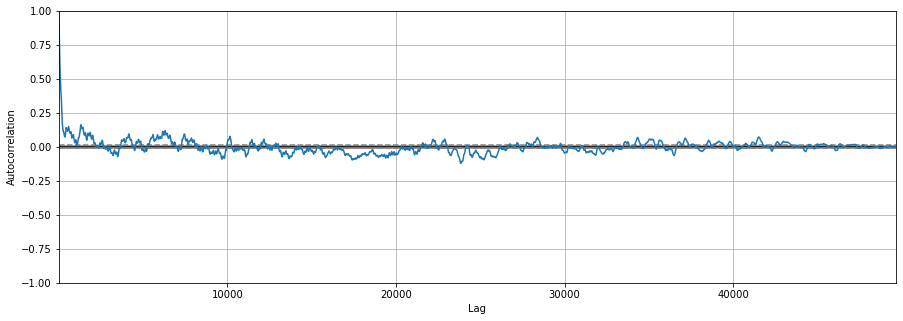

In [40]:
plt.figure(figsize = (15,5))
autocorrelation_plot(train_ws)

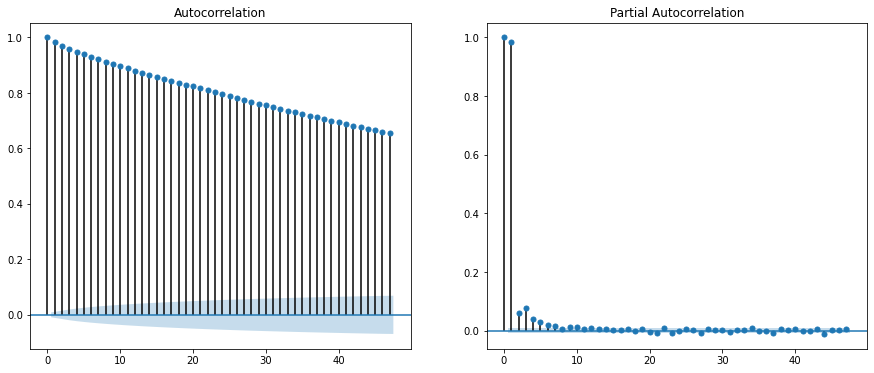

In [41]:
## Check the auto correlation in the series 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 6))
#autocorr = acf(differenced.values) # just the numbers
plot_acf(train_ws.values, ax=ax[0]); # just the plot
plot_pacf(train_ws.values, ax=ax[1]); # just the plot

AR term - lag order is determined from pacf plot.(p) Number of lags that are above the significance level   
MA term - number of lags that are above the significance level in autocorrelation plot of stationary series.(q)   
Diff term - number of differencing required to make the series stationary(d)  

p = 2 , q = very large , d = 0  

In [42]:
def create_test_ARIMA(series,validation,  order , steps):
    
    p = order[0] ## AR term , lag order 
    q = order[1] ## Differencing term 
    r = order[2] ## MA term
    ##
    model = ARIMA(series, order=(p,q,r))
    model_fit = model.fit(disp=0)
    # print summary of fit model
    print(model_fit.summary())
    ##
    # Plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    fig, ax = plt.subplots(1,2, figsize = (15,5))
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()
    ##
    # Actual vs Fitted
    plt.figure(figsize = (15,5))
    model_fit.plot_predict(dynamic=False)
    plt.title("Actual Vs Predicted for Training data ")
    plt.show()
    ##
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(model_fit.resid, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(model_fit.resid, lags=40, ax=ax2)
    plt.show()
    ##
    print(model_fit.resid.describe())
    ##
    predictions, stderr, intervals = model_fit.forecast(steps = steps)
    print("RMSE for  a days  forecast {}".format(mean_squared_error(validation[:steps], predictions, squared = False)))
    ## Plotting the predicted and actual . 
    temp_df = pd.DataFrame(validation[:steps])
    temp_df['predicted'] = predictions
    temp_df['interval1'] = intervals[:,0]
    temp_df['interval2'] = intervals[:,1]
    plt.figure(figsize = (15,5))
    temp_df.plot(style = ['-o', '-o', '--', '--'])

/Users/anushabanninthaya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/anushabanninthaya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


                              ARMA Model Results                              
Dep. Variable:       Wind Speed (m/s)   No. Observations:                49666
Model:                     ARMA(2, 2)   Log Likelihood              -55893.881
Method:                       css-mle   S.D. of innovations              0.746
Date:                Sat, 11 Dec 2021   AIC                         111799.762
Time:                        23:04:49   BIC                         111852.641
Sample:                             0   HQIC                        111816.332
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      7.6143      0.277     27.445      0.000       7.071       8.158
ar.L1.Wind Speed (m/s)     1.5257      0.040     38.304      0.000       1.448       1.604
ar.L

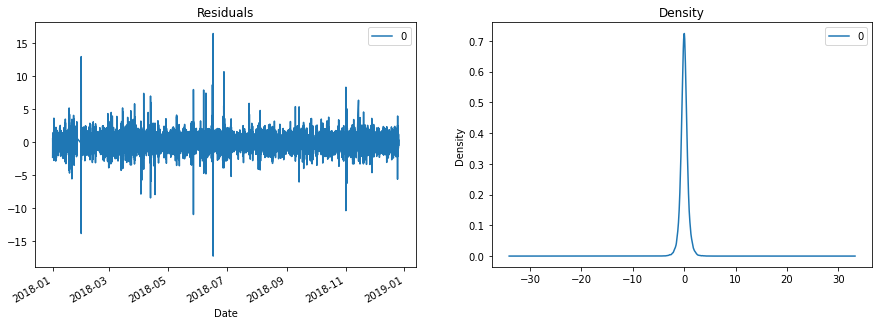

<Figure size 1080x360 with 0 Axes>

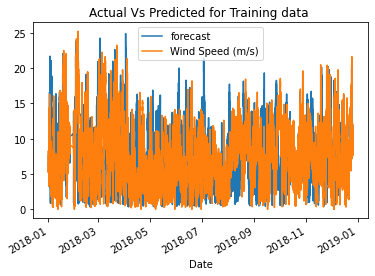

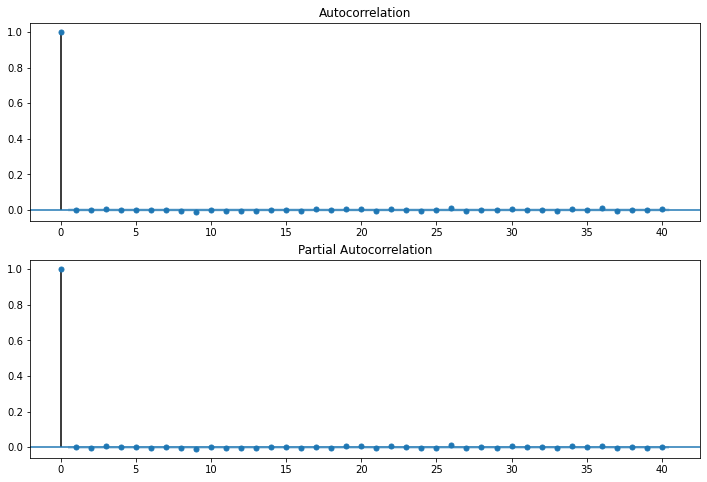

count    49666.000000
mean         0.000073
std          0.745668
min        -17.225736
25%         -0.384441
50%         -0.002437
75%          0.377755
max         16.413094
dtype: float64
RMSE for  a days  forecast 4.227346010726796


<Figure size 1080x360 with 0 Axes>

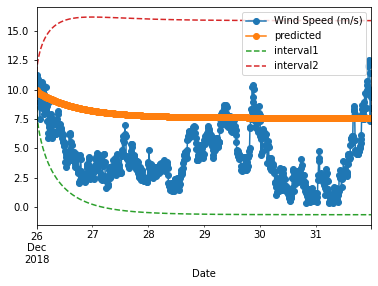

In [43]:
order = [2,0,2]
steps = (6*24*6)
create_test_ARIMA(train_ws, test_ws ,order,steps )

/Users/anushabanninthaya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/anushabanninthaya/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:220: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it is not'


                               ARMA Model Results                              
Dep. Variable:     LV ActivePower (kW)   No. Observations:                49666
Model:                      ARMA(2, 6)   Log Likelihood             -343229.197
Method:                        css-mle   S.D. of innovations            242.688
Date:                 Sat, 11 Dec 2021   AIC                         686478.394
Time:                         17:56:11   BIC                         686566.525
Sample:                              0   HQIC                        686506.009
                                                                               
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1327.6473     84.425     15.726      0.000    1162.177    1493.117
ar.L1.LV ActivePower (kW)     1.6301      0.115     14.113      0.000       1.

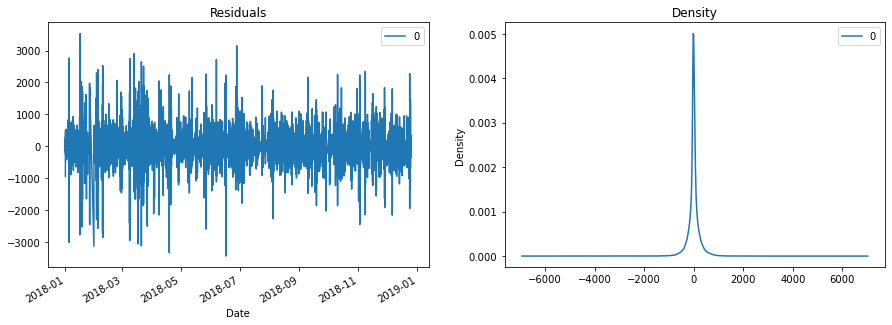

<Figure size 1080x360 with 0 Axes>

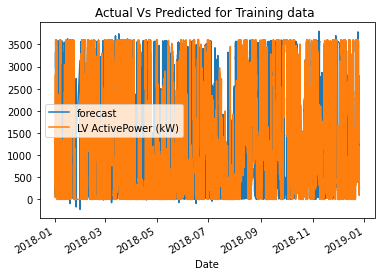

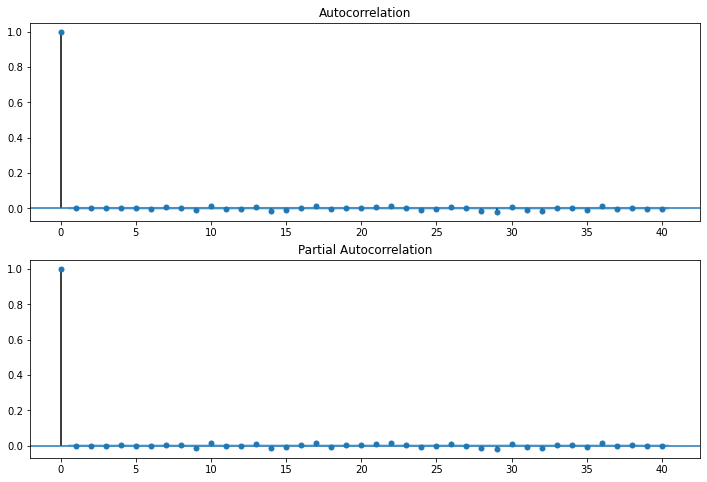

count    49666.000000
mean        -0.022112
std        242.725977
min      -3446.204768
25%        -59.485687
50%        -17.089123
75%         57.704311
max       3533.872545
dtype: float64
RMSE for  a days  forecast 1147.8350171163654


<Figure size 1080x360 with 0 Axes>

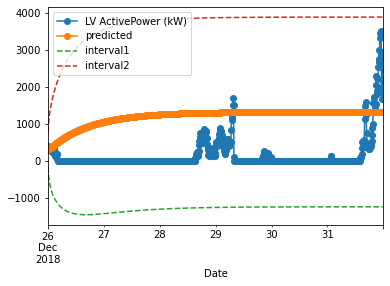

In [29]:
order = [2,0,6]
steps = (6*24*6)
create_test_ARIMA(train_ws, test_ws ,order,steps )